# Modelo RNA para classificação de números usando RNA com dropout

## Importação de bibliotecas

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

## MNIST

In [2]:
(train_img, train_lbs), (test_img, test_lbs) = tf.keras.datasets.mnist.load_data() ### Função do TensorFlow para carregar o dataset MNIST - Ela retorna duas tuplas, uma para treino e outra para teste. O par é composto pelas imagens em 28x28 px e as labels que são os valores de 0 a 9.
train_img = train_img.reshape((60000, 28 * 28)).astype('float32') / 255 ### Redimensionamento para 1D e e normalização para o tipo float entre 0 e 1. Etapa para garantir compatibilidade e convergência.
test_img = test_img.reshape((10000, 28 * 28)).astype('float32') / 255   ### Redimensionamento para 1D e e normalização para o tipo float entre 0 e 1. Etapa para garantir compatibilidade e convergência.

train_lbs = tf.keras.utils.to_categorical(train_lbs) ### Aplicação do OneHotEncoding 
test_lbs = tf.keras.utils.to_categorical(test_lbs) ### Aplicação do OneHotEncoding 

## Ruído

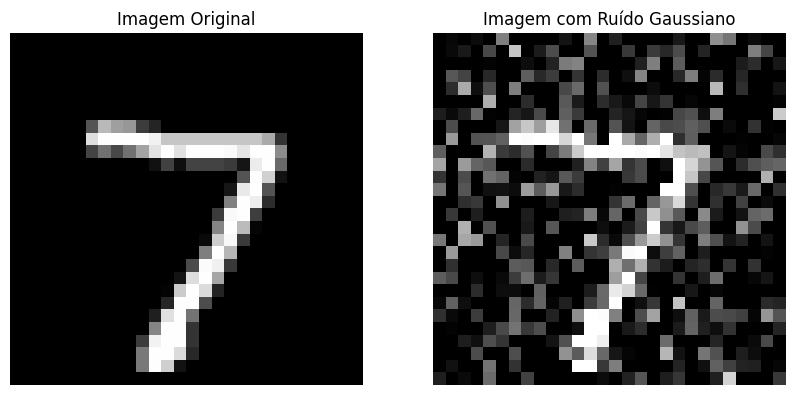

In [3]:
def gaussian_noise(img, mean=0., std=0.1):
    noise = np.random.normal(mean, std, img.shape) ### Função numpy para distribuição normal
    noisy_images = img + noise ### Soma do array da imagem original com o array ruído, gerando um novo array
    noisy_images = np.clip(noisy_images, 0., 1.) ### Aqui os valores do novo array que passam do range 0-1 são corrigidos para seguir a estrutura que definimos anteriormente no MNIST
    return noisy_images

test_img_noisy = gaussian_noise(test_img, std=0.3)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(test_img[0].reshape(28, 28), cmap='gray')
plt.title('Imagem Original')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(test_img_noisy[0].reshape(28, 28), cmap='gray')
plt.title('Imagem com Ruído Gaussiano')
plt.axis('off')
plt.show()

## Definindo e Treinando o modelo

In [4]:
dropout = [0.1, 0.2, 0.3, 0.4, 0.5]
results = {}
results_noisy = {}
trained_models = {}

for rate in dropout:
    print(f"Taxa de Dropout: {rate}")
    model = models.Sequential([
        layers.Dense(64, activation='relu', input_shape=(28*28,)), ### Todos neurônios conectados aos neurônios da camada anterior. Função de ativação ReLU (Unidade Linear Retificada). Retorna o próprio valor de entrada se for positivo, e zero caso contrário
        layers.Dropout(rate), ### Durante o treinamento, ela desativa aleatoriamente uma fração dos neurônios de entrada para esta camada
        layers.Dense(10, activation='softmax') ### Converte saídas brutas dos neurônios em uma distribuição de probabilidade sobre as 10 classes
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(train_img, train_lbs, epochs=20, batch_size=128, verbose=0, validation_data=(test_img, test_lbs))

    test_loss, test_acc = model.evaluate(test_img, test_lbs, verbose=0)
    print(f'Acurácia de teste com Taxa de Dropout {rate}: {test_acc:.4f}')
    results[rate] = test_acc

    test_loss_noisy, test_acc_noisy = model.evaluate(test_img_noisy, test_lbs, verbose=0)
    print(f'Acurácia de teste (com ruído) com Taxa de Dropout {rate}: {test_acc_noisy:.4f}')
    results_noisy[rate] = test_acc_noisy

    trained_models[rate] = model



Taxa de Dropout: 0.1


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Acurácia de teste com Taxa de Dropout 0.1: 0.9777
Acurácia de teste (com ruído) com Taxa de Dropout 0.1: 0.6331
Taxa de Dropout: 0.2
Acurácia de teste com Taxa de Dropout 0.2: 0.9771
Acurácia de teste (com ruído) com Taxa de Dropout 0.2: 0.5346
Taxa de Dropout: 0.3
Acurácia de teste com Taxa de Dropout 0.3: 0.9742
Acurácia de teste (com ruído) com Taxa de Dropout 0.3: 0.6099
Taxa de Dropout: 0.4
Acurácia de teste com Taxa de Dropout 0.4: 0.9699
Acurácia de teste (com ruído) com Taxa de Dropout 0.4: 0.5193
Taxa de Dropout: 0.5
Acurácia de teste com Taxa de Dropout 0.5: 0.9679
Acurácia de teste (com ruído) com Taxa de Dropout 0.5: 0.5001


## Visualizando

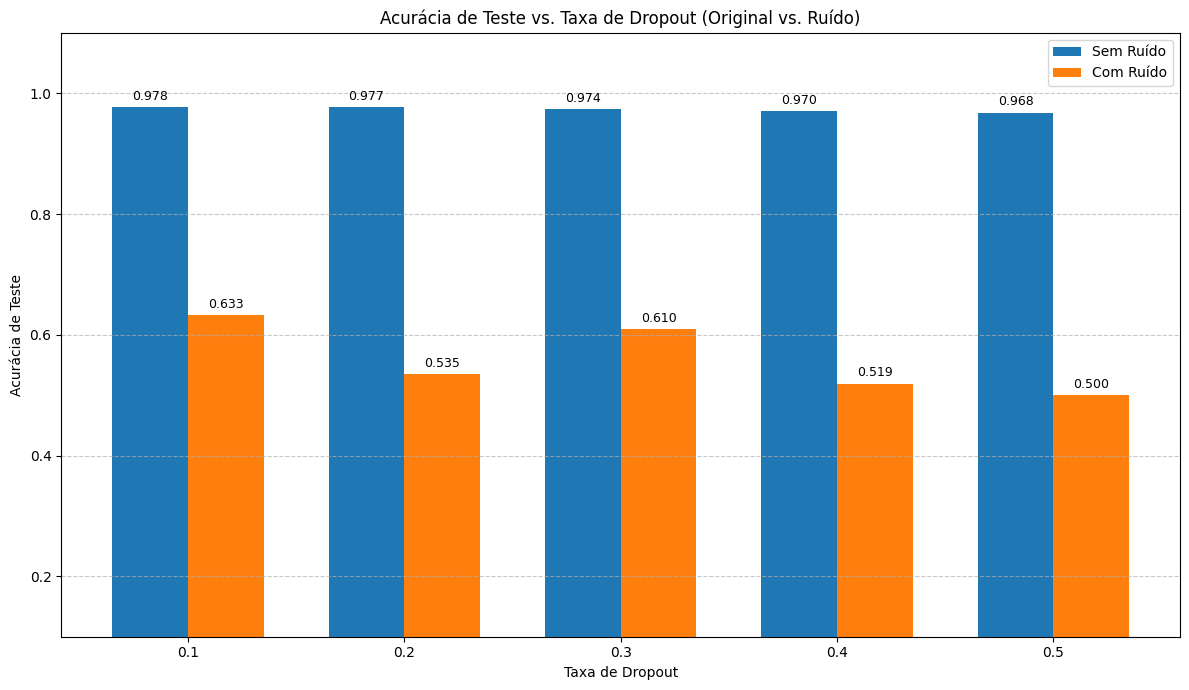

In [5]:
dropout_rates = list(results.keys())
accuracies_original = list(results.values())
accuracies_noisy = list(results_noisy.values())

x = np.arange(len(dropout_rates))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 7))
rects1 = ax.bar(x - width/2, accuracies_original, width, label='Sem Ruído')
rects2 = ax.bar(x + width/2, accuracies_noisy, width, label='Com Ruído')

ax.set_xlabel('Taxa de Dropout')
ax.set_ylabel('Acurácia de Teste')
ax.set_title('Acurácia de Teste vs. Taxa de Dropout (Original vs. Ruído)')
ax.set_xticks(x)
ax.set_xticklabels([str(r) for r in dropout_rates])
ax.set_ylim(0.1, 1.1)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)


for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3), 
                textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

fig.tight_layout()
plt.show()
